# 문자 레벨 기계번역기
### 참조: [sequence-to-sequence 10분만에 이해하기](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)
### 다운로드: [프랑스-영어 병렬 코퍼스](http://www.manythings.org/anki)

## 1. 데이터 확인 및 전처리

In [1]:
import pandas as pd
lines = pd.read_csv('data/fra.txt', names=['src', 'dst', 'desc'], sep='\t')
len(lines)

177210

In [2]:
# 60,000개의 샘플만 가지고 기계 번역기를 구축
lines = lines[0:60000] # 6만개만 저장
lines.sample(5)

,src,dst,desc
47455,He left Japan for good.,Il a quitté le Japon pour de bon.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
5011,Do you get it?,Vous pigez ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
4583,We need help.,Nous avons besoin d'aide.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
6147,It's not fair.,Ce n'est pas équitable.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
54967,I hate people like that.,Je déteste les gens comme ça.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [3]:
# desc 컬럼 삭제
del lines['desc']

In [4]:
# dst 열에 <sos>로 \t, <eos>로 \n 을 추가
lines.dst = lines.dst.apply(lambda x : '\t ' + x + ' \n')
lines.sample(5)

,src,dst
41548,I didn't feel a thing.,\t Je n'ai rien ressenti. \n
32419,Tom's tie is yellow.,\t La cravate de Tom est jaune. \n
1560,Let him go.,\t Laissez-le s'en aller! \n
13154,"What's up, dude?","\t Comment ça va, mec ? \n"
36527,I'm ready if you are.,\t Je suis prêt si vous l'êtes. \n


In [5]:
# 글자 집합 생성 (단어가 아님), 즉 토큰 단위가 단어가 아닌 글자
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 글자씩 읽음
        src_vocab.add(char)

dst_vocab = set()
for line in lines.dst:
    for char in line:
        dst_vocab.add(char)

In [6]:
src_vocab_size = len(src_vocab)+1
dst_vocab_size = len(dst_vocab)+1
print(src_vocab_size, dst_vocab_size)

79 105


In [7]:
src_vocab = sorted(list(src_vocab))
dst_vocab = sorted(list(dst_vocab))
print(src_vocab[45:75])
print(dst_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']


In [8]:
# 각 글자에 인덱스 부여
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
dst_to_index = dict([(word, i+1) for i, word in enumerate(dst_vocab)])
print(src_to_index)
print(dst_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, ',': 11, '-': 12, '.': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, '?': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 3

In [9]:
# 영어 데이터에 대한 정수 인코딩
encoder_input = []
for line in lines.src: #입력 데이터에서 1줄씩 문장을 읽음
    temp_X = []
    for w in line: #각 줄에서 1개씩 글자를 읽음
        temp_X.append(src_to_index[w]) # 글자를 해당되는 정수로 변환
    encoder_input.append(temp_X)
print(encoder_input[:5])

[[30, 64, 10], [31, 58, 10], [31, 58, 10], [41, 70, 63, 2], [41, 70, 63, 2]]


In [10]:
# 프랑스어 데이터에 대한 정수 인코딩
decoder_input = []
for line in lines.dst:
    temp_X = []
    for w in line:
        temp_X.append(dst_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])

[[1, 3, 47, 52, 3, 4, 3, 2], [1, 3, 44, 52, 63, 72, 71, 3, 4, 3, 2], [1, 3, 44, 52, 63, 72, 71, 13, 3, 2], [1, 3, 28, 66, 72, 69, 70, 104, 4, 3, 2], [1, 3, 28, 66, 72, 69, 56, 77, 104, 4, 3, 2]]


In [11]:
# 디코더의 예측값과 비교하기 위한 실제값
# 정수 인코딩 과정에서 <sos>를 제거
decoder_target = []
for line in lines.dst:
    t=0
    temp_X = []
    for w in line:
        if t>0:
            temp_X.append(dst_to_index[w])
        t=t+1
    decoder_target.append(temp_X)
print(decoder_target[:5])

[[3, 47, 52, 3, 4, 3, 2], [3, 44, 52, 63, 72, 71, 3, 4, 3, 2], [3, 44, 52, 63, 72, 71, 13, 3, 2], [3, 28, 66, 72, 69, 70, 104, 4, 3, 2], [3, 28, 66, 72, 69, 56, 77, 104, 4, 3, 2]]


In [12]:
# 패딩을 위해서 영어 문장과 프랑스어 문장 각각에 대해서 가장 길이가 긴 샘플의 길이 확인
max_src_len = max([len(line) for line in lines.src])
max_dst_len = max([len(line) for line in lines.dst])
print(max_src_len, max_dst_len)

25 76


In [13]:
# 평균 샘플 길이
print('영어 문장의 평균 길이 : {}'.format(sum(map(len, lines.src))/len(lines.src)))
print('불어 문장의 평균 길이 : {}'.format(sum(map(len, lines.dst))/len(lines.dst)))

영어 문장의 평균 길이 : 19.27035
불어 문장의 평균 길이 : 28.3092


In [14]:
# 패딩시 사용할 크기
pad_src_len = 25
pad_dst_len = 76

In [15]:
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
encoder_input = pad_sequences(encoder_input, maxlen=pad_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=pad_dst_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=pad_dst_len, padding='post')

Using TensorFlow backend.


In [16]:
# 원-핫 인코딩
from keras.utils import to_categorical
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

## 2. 교사 강요(Teacher forcing)
- 훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고,
- 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용
- RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 교사 강요라고 함

## 3. seq2seq 기계 번역기 훈련시키기

In [17]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

In [18]:
encoder_inputs = Input(shape=(None, src_vocab_size), name='Encoder_Input')
encoder_lstm = LSTM(units=256, return_state=True, name='Encoder_LSTM')
# 인코더의 내부 상태를 디코더로 넘겨주어야 하기 때문에 return_state=True로 설정
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
encoder_states = [state_h, state_c]
# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 바로 은닉 상태와 셀 상태.
# 이겻이 컨텍스트 벡터

In [19]:
decoder_inputs = Input(shape=(None, dst_vocab_size), name='Decoder_Input')
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True, 
                    name='Decoder_LSTM')
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 합니다.

In [20]:
decoder_softmax_layer = Dense(dst_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input (InputLayer)      (None, None, 79)     0                                            
__________________________________________________________________________________________________
Decoder_Input (InputLayer)      (None, None, 105)    0                                            
__________________________________________________________________________________________________
Encoder_LSTM (LSTM)             [(None, 256), (None, 344064      Encoder_Input[0][0]              
__________________________________________________________________________________________________
Decoder_LSTM (LSTM)             [(None, None, 256),  370688      Decoder_Input[0][0]              
                                                                 Encoder_LSTM[0][1]         

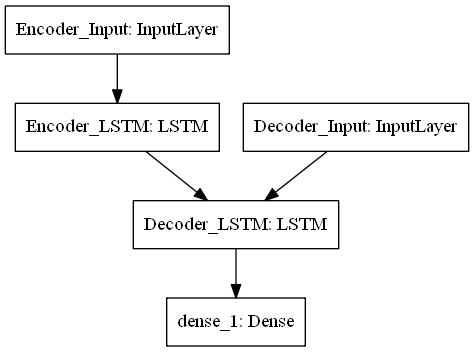

In [21]:
from keras.utils import plot_model
plot_model(model, 'image/seq2seq.png')

In [22]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
modelpath = "model/seq2seq-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)
#early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [24]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target,
          batch_size=64, epochs=50, validation_split=0.2,
          callbacks=[checkpointer])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 276s 6ms/step - loss: 0.7605 - val_loss: 0.6840

Epoch 00001: val_loss improved from inf to 0.68405, saving model to model/seq2seq-01-0.6840.hdf5
Epoch 2/50
48000/48000 [==============================] - 233s 5ms/step - loss: 0.4848 - val_loss: 0.5660

Epoch 00002: val_loss improved from 0.68405 to 0.56600, saving model to model/seq2seq-02-0.5660.hdf5
Epoch 3/50
48000/48000 [==============================] - 319s 7ms/step - loss: 0.4056 - val_loss: 0.4903

Epoch 00003: val_loss improved from 0.56600 to 0.49030, saving model to model/seq2seq-03-0.4903.hdf5
Epoch 4/50
48000/48000 [==============================] - 319s 7ms/step - loss: 0.3588 - val_loss: 0.4495

Epoch 00004: val_loss improved from 0.49030 to 0.44951, saving model to model/seq2seq-04-0.4495.hdf5
Epoch 5/50
48000/48000 [==============================] - 320s 7ms/step - loss: 0.3280 - val_loss: 0.4248

Epoch 00005: va

KeyboardInterrupt: 

## 4. seq2seq 기계 번역기 동작시키기
- 학습한 최종 모델로

In [26]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [27]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태를 이전 상태로 사용
decoder_states = [state_h, state_c]
# 이번에는 훈련 과정에서와 달리 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [28]:
index_to_src = dict(
    (i, char) for char, i in src_to_index.items())
index_to_dst = dict(
    (i, char) for char, i in dst_to_index.items())

In [29]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, dst_vocab_size))
    target_seq[0, 0, dst_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition: #stop_condition이 True가 될 때까지 루프 반복
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_dst[sampled_token_index]
        decoded_sentence += sampled_char

        # <sos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dst_len):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트 합니다.
        target_seq = np.zeros((1, 1, dst_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 상태를 업데이트 합니다.
        states_value = [h, c]

    return decoded_sentence

In [30]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.dst[seq_index][1:len(lines.dst[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Run!
정답 문장:  Cours ! 
번역기가 번역한 문장:  Courez ! 
-----------------------------------
입력 문장: I lost.
정답 문장:  J'ai perdu. 
번역기가 번역한 문장:  J'ai perdu. 
-----------------------------------
입력 문장: Come in.
정답 문장:  Entre ! 
번역기가 번역한 문장:  Entrez ! 
-----------------------------------
입력 문장: I got it.
정답 문장:  J'ai capté. 
번역기가 번역한 문장:  Je l'ai confectionné. 
-----------------------------------
입력 문장: Who cares?
정답 문장:  Qui s'en préoccupe ? 
번역기가 번역한 문장:  Qui s'en soucie ? 


## 5. seq2seq 기계 번역기 동작시키기
- Best 모델로

In [31]:
# Best Model 선택
from keras.models import load_model
del model
model = load_model('model/seq2seq-16-0.3650.hdf5')

In [32]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [33]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태를 이전 상태로 사용
decoder_states = [state_h, state_c]
# 이번에는 훈련 과정에서와 달리 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [34]:
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.dst[seq_index][1:len(lines.dst[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Run!
정답 문장:  Cours ! 
번역기가 번역한 문장:  Courez ! 
-----------------------------------
입력 문장: I lost.
정답 문장:  J'ai perdu. 
번역기가 번역한 문장:  J'ai perdu. 
-----------------------------------
입력 문장: Come in.
정답 문장:  Entre ! 
번역기가 번역한 문장:  Entrez ! 
-----------------------------------
입력 문장: I got it.
정답 문장:  J'ai capté. 
번역기가 번역한 문장:  Je l'ai confectionné. 
-----------------------------------
입력 문장: Who cares?
정답 문장:  Qui s'en préoccupe ? 
번역기가 번역한 문장:  Qui s'en soucie ? 
